# Advancing Chemical Safety Prediction: An Integrated GNN Framework with DFT-augmented Cyclic Compound Solution

- This code implements a GNN with global features.
- The code below was developed based on HoC data, and it can be readily applied to VP and FP simply by substituting the data, as they share the same format.
- Note: The term "global" in this notebook refers to the learned graph-level representation produced by the nfp.GlobalUpdate layer. No external molecular descriptors (e.g., MolWt, TPSA) are concatenated as additional global features in this version.

### Preprocessing
- SMILES canonicalized with RDKit (no salts or duplicates)
- Dataset split: 80/10/10 (train/validation/test), seed = 42
- Target: experimental HoC values (kJ/mol), unscaled
- No additional feature scaling or normalization applied
- Graph construction: atom/bond features follow RDKit defaults

### Hyperparameters
- Layers ∈ {1,…,7}, Hidden dim ∈ {32,64}, Batch size ∈ {16,32,64}
- Optimizer: AdamW(lr=5e-5, weight_decay=1e-5)
- Epochs = 20, Loss = MAE, Dropout = 0.2
- Selection: lowest validation MAE on 80/10/10 split


## 0. Import Libraries

In [1]:
from collections import OrderedDict
import tensorflow as tf
import nfp
from collections import namedtuple
from rdkit import Chem
from rdkit.Chem import AllChem
from nfp.preprocessing.mol_preprocessor import SmilesPreprocessor
from nfp.preprocessing.features import get_ring_size
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import layers
import pandas as pd

## 1. Data Loading
### 1-1. Exploring Data Shape and Structure

In [2]:
data='HoC_230711.csv'
HoC_data=pd.read_csv(data)

<AxesSubplot:ylabel='Frequency'>

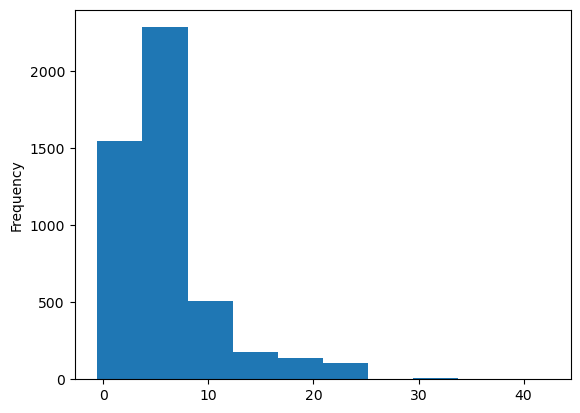

In [3]:
HoC_data.VALUE.plot.hist()

In [4]:
print(HoC_data.columns)

Index(['SMILES', 'Name', 'VALUE'], dtype='object')


In [5]:
print(HoC_data)

                                                 SMILES  \
0     CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...   
1                                    C1Cc2cccc3cccc1c23   
2                                            CCOC(C)OCC   
3                                                  CC=O   
4                                               CC(N)=O   
...                                                 ...   
4775                           CCCCCCCCCCC1CCCc2ccccc12   
4776                        C1Cc2ccccc2C1.C3Cc4ccccc4C3   
4777                                     CC1Cc2ccccc2C1   
4778                                     Cc1cccc2CCCc12   
4779                                     Cc1ccc2CCCc2c1   

                                           Name     VALUE  
0                                  abietic acid  10.96053  
1                                  acenaphthene   6.01352  
2                                        acetal   3.56653  
3                                  acetaldehyde   1

### 1-2. Splitting Data

In [6]:
random_seed = 42
HoC_train = HoC_data.sample(frac=.8, random_state=random_seed)
HoC_valid = HoC_data[~HoC_data.index.isin(HoC_train.index)].sample(frac=.5, random_state=random_seed)
HoC_test = HoC_data[~HoC_data.index.isin(HoC_train.index) & ~HoC_data.index.isin(HoC_valid.index)]

## 2. Fitting GNN model

### 2-1. Hyperparameters tuning

In [7]:
# ---------------------------------------------------------
# Define your hyperparameters to search over
# ---------------------------------------------------------
BATCH_SIZES = [16, 32,64]
LAYERS_LIST = [1,2,3,4, 5, 6, 7]
NUM_FEATURES_LIST = [32, 64]

# Other fixed hyperparameters
LEARNING_RATE = 5.0e-5
EPOCHS = 20
GLOBAL_FEATURE_DIMS = 2

# Define namedtuples for atom and bond types
atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

# ---------------------------------------------------------
# Define function
# ---------------------------------------------------------

# Define atom and bond featurizers
def atom_featurizer(atom):
    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

# Define data generator function
def data_generator(preprocessor, data):
    for _, row in data.iterrows():
        inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
        yield ({'atom': inputs['atom'],
                'bond': inputs['bond'],
                'connectivity': inputs['connectivity']},
               row.VALUE)


preprocessor = SmilesPreprocessor(
    atom_features=atom_featurizer,
    bond_features=bond_featurizer,
    explicit_hs=False)

for smiles in HoC_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))



# ---------------------------------------------------------
# Iterate over hyperparameters
# ---------------------------------------------------------

# Initialize results storage
results = []

for batch_size in BATCH_SIZES:
    for layers in LAYERS_LIST:
        for num_features in NUM_FEATURES_LIST:
            print(f"Testing batch_size={batch_size}, layers={layers}, num_features={num_features}")

            # Create datasets for train and validation
            train_dataset = tf.data.Dataset.from_generator(        
                lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
                .cache().shuffle(buffer_size=200)\
                .padded_batch(batch_size=batch_size)\
                .prefetch(tf.data.experimental.AUTOTUNE)
                
            valid_dataset = tf.data.Dataset.from_generator(        
                lambda: data_generator(preprocessor, HoC_valid), output_signature=output_signature)\
                .cache()\
                .padded_batch(batch_size=batch_size)\
                .prefetch(tf.data.experimental.AUTOTUNE)
                
            
            inputs, outputs = next(train_dataset.as_numpy_iterator())
            
                # Define model architecture
            atom = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='atom')
            bond = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='bond')
            connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')
                
            atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                                       name='atom_embedding', mask_zero=True)(atom)
                
            bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                                       name='bond_embedding', mask_zero=True)(bond)
                
            global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

            for _ in range(layers):
                new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
                bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
                
                new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
                atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
                
                new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
                    [atom_state, bond_state, connectivity, global_state]) 
                global_state = tf.keras.layers.Add()([global_state, new_global_state])
                
            mol_prediction = tf.keras.layers.Dense(1)(global_state)    
            input_tensors = [atom, bond, connectivity]
            
            model = tf.keras.Model([input_tensors], [mol_prediction])
            optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
            model.compile(optimizer, loss='mae')
                
            # Train the model
            hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, verbose=2)
             
            # Evaluate on validation set
            valid_results = model.predict(valid_dataset).squeeze()
            mae_valid = np.abs(valid_results - HoC_valid.VALUE).mean()
            
            # Store hyperparameters and average MAE
            results.append({
                'batch_size': batch_size,
                'layers': layers,
                'num_features': num_features,
                'mae_valid': mae_valid
            })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df)


# Select best hyperparameters
best_hyperparameters = results_df.loc[results_df['mae_valid'].idxmin()]
batch_size = int(best_hyperparameters['batch_size'])
layers = int(best_hyperparameters['layers'])
num_features = int(best_hyperparameters['num_features'])

# ---------------------------------------------------------
# Train the final model on the combined train and validation data with best hyperparameters
# ---------------------------------------------------------
train_dataset_final = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

# Define model architecture with the best hyperparameters
atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                       name='atom_embedding', mask_zero=True)(atom)
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                       name='bond_embedding', mask_zero=True)(bond)
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(layers):
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = tf.keras.layers.Add()([global_state, new_global_state])

mol_prediction = tf.keras.layers.Dense(1)(global_state)    
input_tensors = [atom, bond, connectivity]

model = tf.keras.Model([input_tensors], [mol_prediction])
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
model.compile(optimizer, loss='mae')

# Train the final model on combined train and validation data
model.fit(train_dataset_final, epochs=EPOCHS, verbose=2)

# ---------------------------------------------------------
# Evaluate the final model on test data
# ---------------------------------------------------------
test_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_test), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_results = model.predict(test_dataset).squeeze()
mae_test = np.abs(test_results - HoC_test.VALUE).mean()
print(f"Final model evaluation on test data: MAE = {mae_test}")


Testing batch_size=16, layers=1, num_features=32
Epoch 1/20
239/239 - 7s - loss: 5.6803 - val_loss: 3.4024 - 7s/epoch - 30ms/step
Epoch 2/20
239/239 - 1s - loss: 2.4474 - val_loss: 2.1862 - 830ms/epoch - 3ms/step
Epoch 3/20
239/239 - 1s - loss: 1.9612 - val_loss: 2.0048 - 839ms/epoch - 4ms/step
Epoch 4/20
239/239 - 1s - loss: 1.8155 - val_loss: 1.8847 - 852ms/epoch - 4ms/step
Epoch 5/20
239/239 - 1s - loss: 1.7090 - val_loss: 1.7829 - 841ms/epoch - 4ms/step
Epoch 6/20
239/239 - 1s - loss: 1.6176 - val_loss: 1.6871 - 848ms/epoch - 4ms/step
Epoch 7/20
239/239 - 1s - loss: 1.5195 - val_loss: 1.6010 - 864ms/epoch - 4ms/step
Epoch 8/20
239/239 - 1s - loss: 1.4191 - val_loss: 1.4692 - 847ms/epoch - 4ms/step
Epoch 9/20
239/239 - 1s - loss: 1.3233 - val_loss: 1.3577 - 856ms/epoch - 4ms/step
Epoch 10/20
239/239 - 1s - loss: 1.2304 - val_loss: 1.2661 - 834ms/epoch - 3ms/step
Epoch 11/20
239/239 - 1s - loss: 1.1509 - val_loss: 1.1829 - 857ms/epoch - 4ms/step
Epoch 12/20
239/239 - 1s - loss: 1.075

Epoch 16/20
239/239 - 2s - loss: 0.4153 - val_loss: 0.3719 - 2s/epoch - 9ms/step
Epoch 17/20
239/239 - 2s - loss: 0.4077 - val_loss: 0.5868 - 2s/epoch - 9ms/step
Epoch 18/20
239/239 - 2s - loss: 0.3711 - val_loss: 0.3615 - 2s/epoch - 10ms/step
Epoch 19/20
239/239 - 2s - loss: 0.3602 - val_loss: 0.3731 - 2s/epoch - 9ms/step
Epoch 20/20
239/239 - 2s - loss: 0.3820 - val_loss: 0.6971 - 2s/epoch - 9ms/step
30/30 [==============================] - 1s 4ms/step
Testing batch_size=16, layers=3, num_features=64
Epoch 1/20
239/239 - 13s - loss: 2.5126 - val_loss: 1.5397 - 13s/epoch - 53ms/step
Epoch 2/20
239/239 - 5s - loss: 1.2584 - val_loss: 1.1934 - 5s/epoch - 19ms/step
Epoch 3/20
239/239 - 5s - loss: 0.9752 - val_loss: 1.8906 - 5s/epoch - 19ms/step
Epoch 4/20
239/239 - 5s - loss: 0.8353 - val_loss: 0.7672 - 5s/epoch - 19ms/step
Epoch 5/20
239/239 - 5s - loss: 0.7296 - val_loss: 1.3317 - 5s/epoch - 19ms/step
Epoch 6/20
239/239 - 5s - loss: 0.6369 - val_loss: 0.5942 - 5s/epoch - 19ms/step
Epoc

Epoch 10/20
239/239 - 12s - loss: 0.3234 - val_loss: 0.3597 - 12s/epoch - 49ms/step
Epoch 11/20
239/239 - 11s - loss: 0.3386 - val_loss: 0.4763 - 11s/epoch - 45ms/step
Epoch 12/20
239/239 - 11s - loss: 0.3044 - val_loss: 0.2626 - 11s/epoch - 46ms/step
Epoch 13/20
239/239 - 11s - loss: 0.3494 - val_loss: 0.2917 - 11s/epoch - 47ms/step
Epoch 14/20
239/239 - 11s - loss: 0.3017 - val_loss: 0.4269 - 11s/epoch - 46ms/step
Epoch 15/20
239/239 - 12s - loss: 0.3608 - val_loss: 0.3331 - 12s/epoch - 49ms/step
Epoch 16/20
239/239 - 12s - loss: 0.2574 - val_loss: 0.2506 - 12s/epoch - 52ms/step
Epoch 17/20
239/239 - 13s - loss: 0.2516 - val_loss: 0.3234 - 13s/epoch - 54ms/step
Epoch 18/20
239/239 - 12s - loss: 0.2993 - val_loss: 0.2710 - 12s/epoch - 51ms/step
Epoch 19/20
239/239 - 12s - loss: 0.2593 - val_loss: 0.4822 - 12s/epoch - 50ms/step
Epoch 20/20
239/239 - 11s - loss: 0.2431 - val_loss: 0.3509 - 11s/epoch - 46ms/step
30/30 [==============================] - 2s 13ms/step
Testing batch_size=16,

Epoch 3/20
120/120 - 2s - loss: 2.4622 - val_loss: 2.2973 - 2s/epoch - 13ms/step
Epoch 4/20
120/120 - 2s - loss: 2.0412 - val_loss: 2.0357 - 2s/epoch - 13ms/step
Epoch 5/20
120/120 - 2s - loss: 1.8409 - val_loss: 1.8960 - 2s/epoch - 13ms/step
Epoch 6/20
120/120 - 1s - loss: 1.7332 - val_loss: 1.8023 - 1s/epoch - 12ms/step
Epoch 7/20
120/120 - 2s - loss: 1.6383 - val_loss: 1.7239 - 2s/epoch - 13ms/step
Epoch 8/20
120/120 - 2s - loss: 1.5664 - val_loss: 1.6561 - 2s/epoch - 13ms/step
Epoch 9/20
120/120 - 1s - loss: 1.4969 - val_loss: 1.5979 - 1s/epoch - 12ms/step
Epoch 10/20
120/120 - 2s - loss: 1.4461 - val_loss: 1.5127 - 2s/epoch - 13ms/step
Epoch 11/20
120/120 - 2s - loss: 1.3805 - val_loss: 1.4463 - 2s/epoch - 13ms/step
Epoch 12/20
120/120 - 2s - loss: 1.3172 - val_loss: 1.3898 - 2s/epoch - 13ms/step
Epoch 13/20
120/120 - 2s - loss: 1.2525 - val_loss: 1.3231 - 2s/epoch - 13ms/step
Epoch 14/20
120/120 - 2s - loss: 1.1809 - val_loss: 1.2292 - 2s/epoch - 13ms/step
Epoch 15/20
120/120 - 2

Epoch 19/20
120/120 - 4s - loss: 0.4778 - val_loss: 0.4653 - 4s/epoch - 31ms/step
Epoch 20/20
120/120 - 4s - loss: 0.4555 - val_loss: 0.4686 - 4s/epoch - 31ms/step
15/15 [==============================] - 1s 13ms/step
Testing batch_size=32, layers=3, num_features=64
Epoch 1/20
120/120 - 13s - loss: 3.4124 - val_loss: 2.0375 - 13s/epoch - 111ms/step
Epoch 2/20
120/120 - 7s - loss: 1.6263 - val_loss: 1.4080 - 7s/epoch - 58ms/step
Epoch 3/20
120/120 - 7s - loss: 1.1460 - val_loss: 1.0293 - 7s/epoch - 58ms/step
Epoch 4/20
120/120 - 7s - loss: 0.8450 - val_loss: 0.8974 - 7s/epoch - 57ms/step
Epoch 5/20
120/120 - 7s - loss: 0.6689 - val_loss: 0.6157 - 7s/epoch - 58ms/step
Epoch 6/20
120/120 - 7s - loss: 0.5569 - val_loss: 0.7688 - 7s/epoch - 59ms/step
Epoch 7/20
120/120 - 7s - loss: 0.5245 - val_loss: 0.5183 - 7s/epoch - 58ms/step
Epoch 8/20
120/120 - 7s - loss: 0.4828 - val_loss: 0.5274 - 7s/epoch - 58ms/step
Epoch 9/20
120/120 - 7s - loss: 0.4800 - val_loss: 0.5567 - 7s/epoch - 58ms/step
E

Epoch 13/20
120/120 - 27s - loss: 0.3470 - val_loss: 0.3032 - 27s/epoch - 223ms/step
Epoch 14/20
120/120 - 27s - loss: 0.2990 - val_loss: 0.2862 - 27s/epoch - 221ms/step
Epoch 15/20
120/120 - 27s - loss: 0.2948 - val_loss: 0.2815 - 27s/epoch - 225ms/step
Epoch 16/20
120/120 - 27s - loss: 0.3061 - val_loss: 0.3478 - 27s/epoch - 222ms/step
Epoch 17/20
120/120 - 27s - loss: 0.2551 - val_loss: 0.3067 - 27s/epoch - 224ms/step
Epoch 18/20
120/120 - 27s - loss: 0.3162 - val_loss: 0.3289 - 27s/epoch - 222ms/step
Epoch 19/20
120/120 - 27s - loss: 0.2596 - val_loss: 0.2487 - 27s/epoch - 224ms/step
Epoch 20/20
120/120 - 27s - loss: 0.2462 - val_loss: 0.3176 - 27s/epoch - 221ms/step
15/15 [==============================] - 2s 51ms/step
Testing batch_size=32, layers=6, num_features=32
Epoch 1/20
120/120 - 26s - loss: 2.6306 - val_loss: 1.4978 - 26s/epoch - 213ms/step
Epoch 2/20
120/120 - 14s - loss: 1.1848 - val_loss: 1.0302 - 14s/epoch - 118ms/step
Epoch 3/20
120/120 - 14s - loss: 0.9163 - val_los

Epoch 4/20
60/60 - 2s - loss: 3.7056 - val_loss: 3.2505 - 2s/epoch - 38ms/step
Epoch 5/20
60/60 - 2s - loss: 2.8958 - val_loss: 2.9112 - 2s/epoch - 38ms/step
Epoch 6/20
60/60 - 2s - loss: 2.5831 - val_loss: 2.5634 - 2s/epoch - 39ms/step
Epoch 7/20
60/60 - 2s - loss: 2.3005 - val_loss: 2.3049 - 2s/epoch - 38ms/step
Epoch 8/20
60/60 - 2s - loss: 2.1072 - val_loss: 2.1760 - 2s/epoch - 38ms/step
Epoch 9/20
60/60 - 2s - loss: 1.9925 - val_loss: 2.0776 - 2s/epoch - 38ms/step
Epoch 10/20
60/60 - 2s - loss: 1.8992 - val_loss: 1.9882 - 2s/epoch - 38ms/step
Epoch 11/20
60/60 - 2s - loss: 1.8241 - val_loss: 1.9237 - 2s/epoch - 38ms/step
Epoch 12/20
60/60 - 2s - loss: 1.7502 - val_loss: 1.8548 - 2s/epoch - 38ms/step
Epoch 13/20
60/60 - 2s - loss: 1.6926 - val_loss: 1.8037 - 2s/epoch - 39ms/step
Epoch 14/20
60/60 - 2s - loss: 1.6404 - val_loss: 1.7566 - 2s/epoch - 38ms/step
Epoch 15/20
60/60 - 2s - loss: 1.5951 - val_loss: 1.6947 - 2s/epoch - 38ms/step
Epoch 16/20
60/60 - 2s - loss: 1.5460 - val_lo

Testing batch_size=64, layers=3, num_features=64
Epoch 1/20
60/60 - 16s - loss: 4.5311 - val_loss: 2.5551 - 16s/epoch - 266ms/step
Epoch 2/20
60/60 - 10s - loss: 1.9752 - val_loss: 1.8236 - 10s/epoch - 159ms/step
Epoch 3/20
60/60 - 9s - loss: 1.5783 - val_loss: 1.5610 - 9s/epoch - 158ms/step
Epoch 4/20
60/60 - 9s - loss: 1.3031 - val_loss: 1.2567 - 9s/epoch - 155ms/step
Epoch 5/20
60/60 - 9s - loss: 1.0607 - val_loss: 1.0780 - 9s/epoch - 158ms/step
Epoch 6/20
60/60 - 9s - loss: 0.9439 - val_loss: 0.9319 - 9s/epoch - 157ms/step
Epoch 7/20
60/60 - 9s - loss: 0.8354 - val_loss: 0.8406 - 9s/epoch - 157ms/step
Epoch 8/20
60/60 - 10s - loss: 0.7593 - val_loss: 0.7849 - 10s/epoch - 158ms/step
Epoch 9/20
60/60 - 9s - loss: 0.7632 - val_loss: 0.7752 - 9s/epoch - 157ms/step
Epoch 10/20
60/60 - 9s - loss: 0.6227 - val_loss: 0.6382 - 9s/epoch - 158ms/step
Epoch 11/20
60/60 - 9s - loss: 0.5761 - val_loss: 0.7133 - 9s/epoch - 158ms/step
Epoch 12/20
60/60 - 9s - loss: 0.5899 - val_loss: 0.5529 - 9s/e

60/60 - 19s - loss: 0.2723 - val_loss: 0.2937 - 19s/epoch - 322ms/step
Epoch 17/20
60/60 - 19s - loss: 0.2585 - val_loss: 0.3393 - 19s/epoch - 321ms/step
Epoch 18/20
60/60 - 19s - loss: 0.2555 - val_loss: 0.2583 - 19s/epoch - 321ms/step
Epoch 19/20
60/60 - 19s - loss: 0.2503 - val_loss: 0.2817 - 19s/epoch - 321ms/step
Epoch 20/20
60/60 - 19s - loss: 0.2800 - val_loss: 0.3549 - 19s/epoch - 321ms/step
8/8 [==============================] - 2s 88ms/step
Testing batch_size=64, layers=6, num_features=32
Epoch 1/20
60/60 - 23s - loss: 4.9439 - val_loss: 2.7457 - 23s/epoch - 391ms/step
Epoch 2/20
60/60 - 10s - loss: 1.8839 - val_loss: 1.5476 - 10s/epoch - 172ms/step
Epoch 3/20
60/60 - 10s - loss: 1.2858 - val_loss: 1.2733 - 10s/epoch - 171ms/step
Epoch 4/20
60/60 - 10s - loss: 1.0891 - val_loss: 1.1020 - 10s/epoch - 168ms/step
Epoch 5/20
60/60 - 10s - loss: 0.9356 - val_loss: 0.9326 - 10s/epoch - 171ms/step
Epoch 6/20
60/60 - 10s - loss: 0.7959 - val_loss: 0.8016 - 10s/epoch - 171ms/step
Epoc

Epoch 1/20
120/120 - 35s - loss: 2.1428 - 35s/epoch - 290ms/step
Epoch 2/20
120/120 - 26s - loss: 0.9596 - 26s/epoch - 215ms/step
Epoch 3/20
120/120 - 26s - loss: 0.7462 - 26s/epoch - 215ms/step
Epoch 4/20
120/120 - 26s - loss: 0.5701 - 26s/epoch - 215ms/step
Epoch 5/20
120/120 - 26s - loss: 0.4939 - 26s/epoch - 215ms/step
Epoch 6/20
120/120 - 26s - loss: 0.4166 - 26s/epoch - 214ms/step
Epoch 7/20
120/120 - 26s - loss: 0.4084 - 26s/epoch - 214ms/step
Epoch 8/20
120/120 - 26s - loss: 0.3786 - 26s/epoch - 213ms/step
Epoch 9/20
120/120 - 25s - loss: 0.3614 - 25s/epoch - 212ms/step
Epoch 10/20
120/120 - 25s - loss: 0.3400 - 25s/epoch - 212ms/step
Epoch 11/20
120/120 - 25s - loss: 0.3265 - 25s/epoch - 212ms/step
Epoch 12/20
120/120 - 25s - loss: 0.3731 - 25s/epoch - 212ms/step
Epoch 13/20
120/120 - 25s - loss: 0.3267 - 25s/epoch - 212ms/step
Epoch 14/20
120/120 - 25s - loss: 0.2916 - 25s/epoch - 212ms/step
Epoch 15/20
120/120 - 26s - loss: 0.2768 - 26s/epoch - 213ms/step
Epoch 16/20
120/120

In [8]:
best_hyperparameters

batch_size      32.000000
layers           6.000000
num_features    64.000000
mae_valid        0.227635
Name: 25, dtype: float64

## 2-2. Final GNN model fitting using the Best Hyperparameters

### 2-2-1. Dataset summary

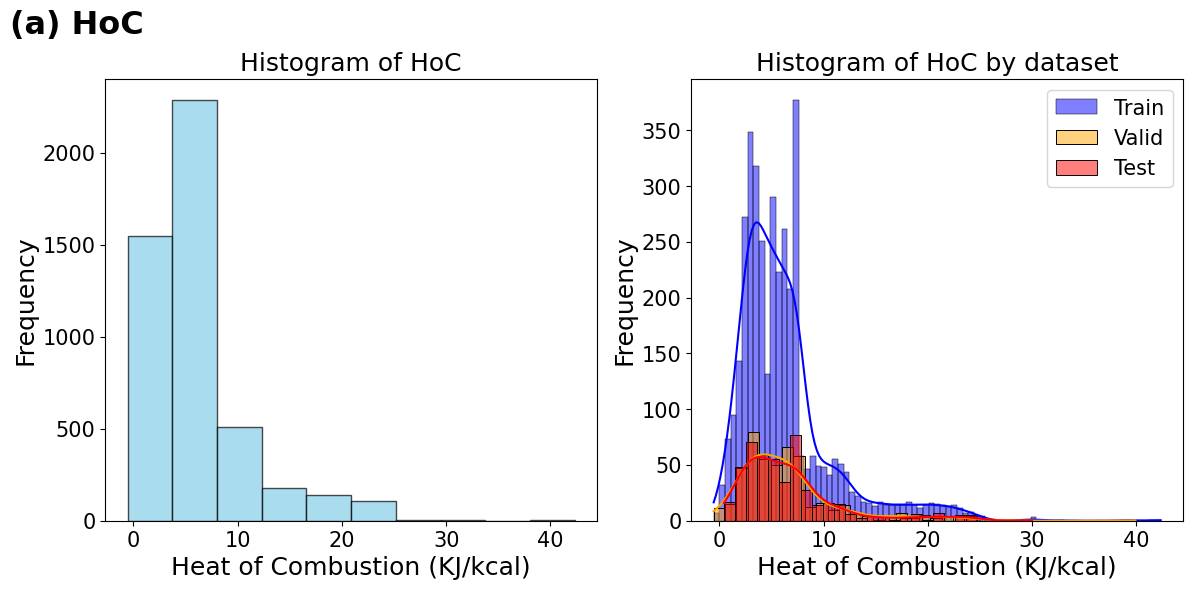

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# subplot -(1)
axes[0].hist(HoC_data['VALUE'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram of HoC', fontsize=18)
axes[0].set_xlabel('Heat of Combustion (KJ/kcal)', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)

# subplot - (2)
sns.histplot(HoC_train['VALUE'], color='blue', label='Train', kde=True, ax=axes[1])
sns.histplot(HoC_valid['VALUE'], color='orange', label='Valid', kde=True, ax=axes[1])
sns.histplot(HoC_test['VALUE'], color='red', label='Test', kde=True, ax=axes[1])
axes[1].set_title('Histogram of HoC by dataset', fontsize=18)
axes[1].set_xlabel('Heat of Combustion (KJ/kcal)', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[1].legend()

# subtitle
fig.text(0.01, 0.95, "(a) HoC",
         ha='left', va='center', fontsize=23, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### 2-2-2. Model training

Epoch 1/100
120/120 - 39s - loss: 1.8148 - val_loss: 0.9658 - 39s/epoch - 322ms/step
Epoch 2/100
120/120 - 28s - loss: 0.8843 - val_loss: 1.1557 - 28s/epoch - 229ms/step
Epoch 3/100
120/120 - 28s - loss: 0.6629 - val_loss: 0.5378 - 28s/epoch - 230ms/step
Epoch 4/100
120/120 - 27s - loss: 0.5507 - val_loss: 0.5051 - 27s/epoch - 227ms/step
Epoch 5/100
120/120 - 27s - loss: 0.4543 - val_loss: 0.5129 - 27s/epoch - 227ms/step
Epoch 6/100
120/120 - 27s - loss: 0.4595 - val_loss: 0.3643 - 27s/epoch - 226ms/step
Epoch 7/100
120/120 - 27s - loss: 0.4044 - val_loss: 0.4299 - 27s/epoch - 223ms/step
Epoch 8/100
120/120 - 27s - loss: 0.3565 - val_loss: 0.3903 - 27s/epoch - 227ms/step
Epoch 9/100
120/120 - 27s - loss: 0.3136 - val_loss: 0.4436 - 27s/epoch - 227ms/step
Epoch 10/100
120/120 - 27s - loss: 0.3104 - val_loss: 0.5439 - 27s/epoch - 224ms/step
Epoch 11/100
120/120 - 27s - loss: 0.2831 - val_loss: 0.3726 - 27s/epoch - 227ms/step
Epoch 12/100
120/120 - 27s - loss: 0.2618 - val_loss: 0.2798 - 

Epoch 97/100
120/120 - 27s - loss: 0.1499 - val_loss: 0.2483 - 27s/epoch - 226ms/step
Epoch 98/100
120/120 - 27s - loss: 0.1708 - val_loss: 0.2318 - 27s/epoch - 225ms/step
Epoch 99/100
120/120 - 27s - loss: 0.1735 - val_loss: 0.2307 - 27s/epoch - 224ms/step
Epoch 100/100
120/120 - 27s - loss: 0.1463 - val_loss: 0.1531 - 27s/epoch - 225ms/step


<AxesSubplot:>

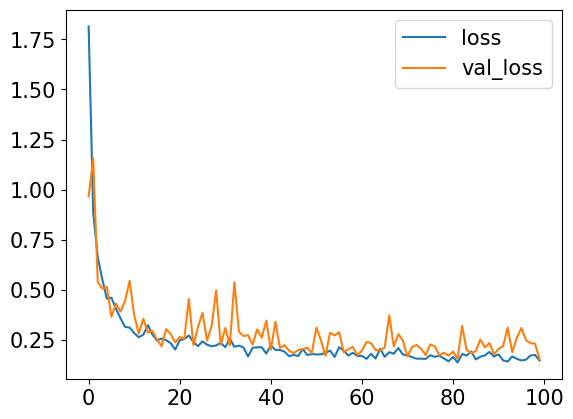

In [11]:
import random
# set random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
layers = 6
num_features = 64
LEARNING_RATE = 0.0001

EPOCHS=100

# Define namedtuples for atom and bond types
atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

# ---------------------------------------------------------
# Define function
# ---------------------------------------------------------

# Define atom and bond featurizers
def atom_featurizer(atom):
    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

# Define data generator function
def data_generator(preprocessor, data):
    for _, row in data.iterrows():
        inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
        yield ({'atom': inputs['atom'],
                'bond': inputs['bond'],
                'connectivity': inputs['connectivity']},
               row.VALUE)


preprocessor = SmilesPreprocessor(
    atom_features=atom_featurizer,
    bond_features=bond_featurizer,
    explicit_hs=False)

for smiles in HoC_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))

train_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_valid), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

train_dataset_final = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_test), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

inputs, outputs = next(train_dataset.as_numpy_iterator())

# ---------------------------------------------------------
# Define model architecture
# ---------------------------------------------------------
atom = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')

atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                       name='atom_embedding', mask_zero=True)(atom)
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                       name='bond_embedding', mask_zero=True)(bond)
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(layers):
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = tf.keras.layers.Add()([global_state, new_global_state])

mol_prediction = tf.keras.layers.Dense(1)(global_state)    
input_tensors = [atom, bond, connectivity]

model = tf.keras.Model([input_tensors], [mol_prediction])
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
model.compile(optimizer, loss='mae')
# ---------------------------------------------------------
# Train the final model on combined train and validation data
# ---------------------------------------------------------
hist = model.fit(train_dataset,  validation_data=valid_dataset, epochs=EPOCHS, verbose=2)

pd.DataFrame(hist.history).plot.line()




In [12]:
# ---------------------------------------------------------
# Evaluate on validation set
# ---------------------------------------------------------
train_results = model.predict(train_dataset_final).squeeze()
valid_results = model.predict(valid_dataset).squeeze()
test_results = model.predict(test_dataset).squeeze()

mae_train = np.abs(train_results - HoC_train.VALUE).mean()
mae_valid = np.abs(valid_results - HoC_valid.VALUE).mean()
mae_test = np.abs(test_results - HoC_test.VALUE).mean()

15/15 [==============================] - 1s 60ms/step


In [13]:
from sklearn.metrics import r2_score

# R2 
r2_train = r2_score(HoC_train.VALUE, train_results)
r2_valid = r2_score(HoC_valid.VALUE, valid_results)
r2_test = r2_score(HoC_test.VALUE, test_results)

# print : MAE
print(f"MAE Train: {mae_train}")
print(f"MAE Valid: {mae_valid}")
print(f"MAE Test: {mae_test}")

# print : R2
print(f"R2 Train: {r2_train}")
print(f"R2 Valid: {r2_valid}")
print(f"R2 Test: {r2_test}")

MAE Train: 0.10249480360245479
MAE Valid: 0.1530753598194554
MAE Test: 0.1258967247686745
R2 Train: 0.9935103531218614
R2 Valid: 0.9893332900491579
R2 Test: 0.9925522041968375


### 2-2-3. Bootstrap CI

In [15]:
# ---------------------------------------------------------
# Bootstrap confidence intervals for test-set performance
# ---------------------------------------------------------

import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import norm

# ---------------------------------------------------------
# 0. Extract true/predicted values
# ---------------------------------------------------------
y_true = HoC_test.VALUE.to_numpy()
y_pred = np.asarray(test_results)
n = len(y_true)

# ---------------------------------------------------------
# 1. Point estimates on the original test set
# ---------------------------------------------------------
mae_hat = mean_absolute_error(y_true, y_pred)
r2_hat = r2_score(y_true, y_pred)

# ---------------------------------------------------------
# 2. Bootstrap sampling
# ---------------------------------------------------------
B = 1000
rng = np.random.default_rng(42)

mae_boot = np.empty(B)
r2_boot = np.empty(B)

for b in range(B):
    idx = rng.integers(0, n, n)  # sample n indices with replacement
    yt_b = y_true[idx]
    yp_b = y_pred[idx]
    mae_boot[b] = mean_absolute_error(yt_b, yp_b)
    r2_boot[b] = r2_score(yt_b, yp_b)

# ---------------------------------------------------------
# 3. Bias-corrected (BC) confidence interval
# ---------------------------------------------------------
def bc_ci(boot_stats, theta_hat, alpha=0.05):
    """
    boot_stats : array of bootstrap statistics (B,)
    theta_hat  : point estimate from original data
    alpha      : significance level (0.05 → 95% CI)
    """
    boot_stats = np.sort(boot_stats)
    B = len(boot_stats)

    # Bias-correction factor z0
    prop_less = np.mean(boot_stats < theta_hat)
    prop_less = np.clip(prop_less, 1e-6, 1 - 1e-6)  # avoid 0 or 1
    z0 = norm.ppf(prop_less)

    # Standard normal quantiles
    z_low = norm.ppf(alpha / 2)
    z_high = norm.ppf(1 - alpha / 2)

    # Adjusted percentile locations
    pct_low = norm.cdf(2 * z0 + z_low)
    pct_high = norm.cdf(2 * z0 + z_high)

    return (
        np.percentile(boot_stats, pct_low * 100),
        np.percentile(boot_stats, pct_high * 100),
    )

# ---------------------------------------------------------
# 4. Compute CI for MAE and R²
# ---------------------------------------------------------
mae_ci_low, mae_ci_high = bc_ci(mae_boot, mae_hat, alpha=0.05)
r2_ci_low, r2_ci_high   = bc_ci(r2_boot,  r2_hat,  alpha=0.05)

# ---------------------------------------------------------
# 5. Output
# ---------------------------------------------------------
print("=== Test set performance (Bias-corrected bootstrap 95% CI) ===")
print(f"MAE: {mae_hat:.4f}  (95% BC CI: {mae_ci_low:.4f}, {mae_ci_high:.4f})")
print(f"R² : {r2_hat:.4f}  (95% BC CI: {r2_ci_low:.4f}, {r2_ci_high:.4f})")


=== Test set performance (Bias-corrected bootstrap 95% CI) ===
MAE: 0.1259  (95% BC CI: 0.0956, 0.1671)
R² : 0.9926  (95% BC CI: 0.9852, 0.9974)


### 2-2-4. Residual Visualization and Outlier Detection

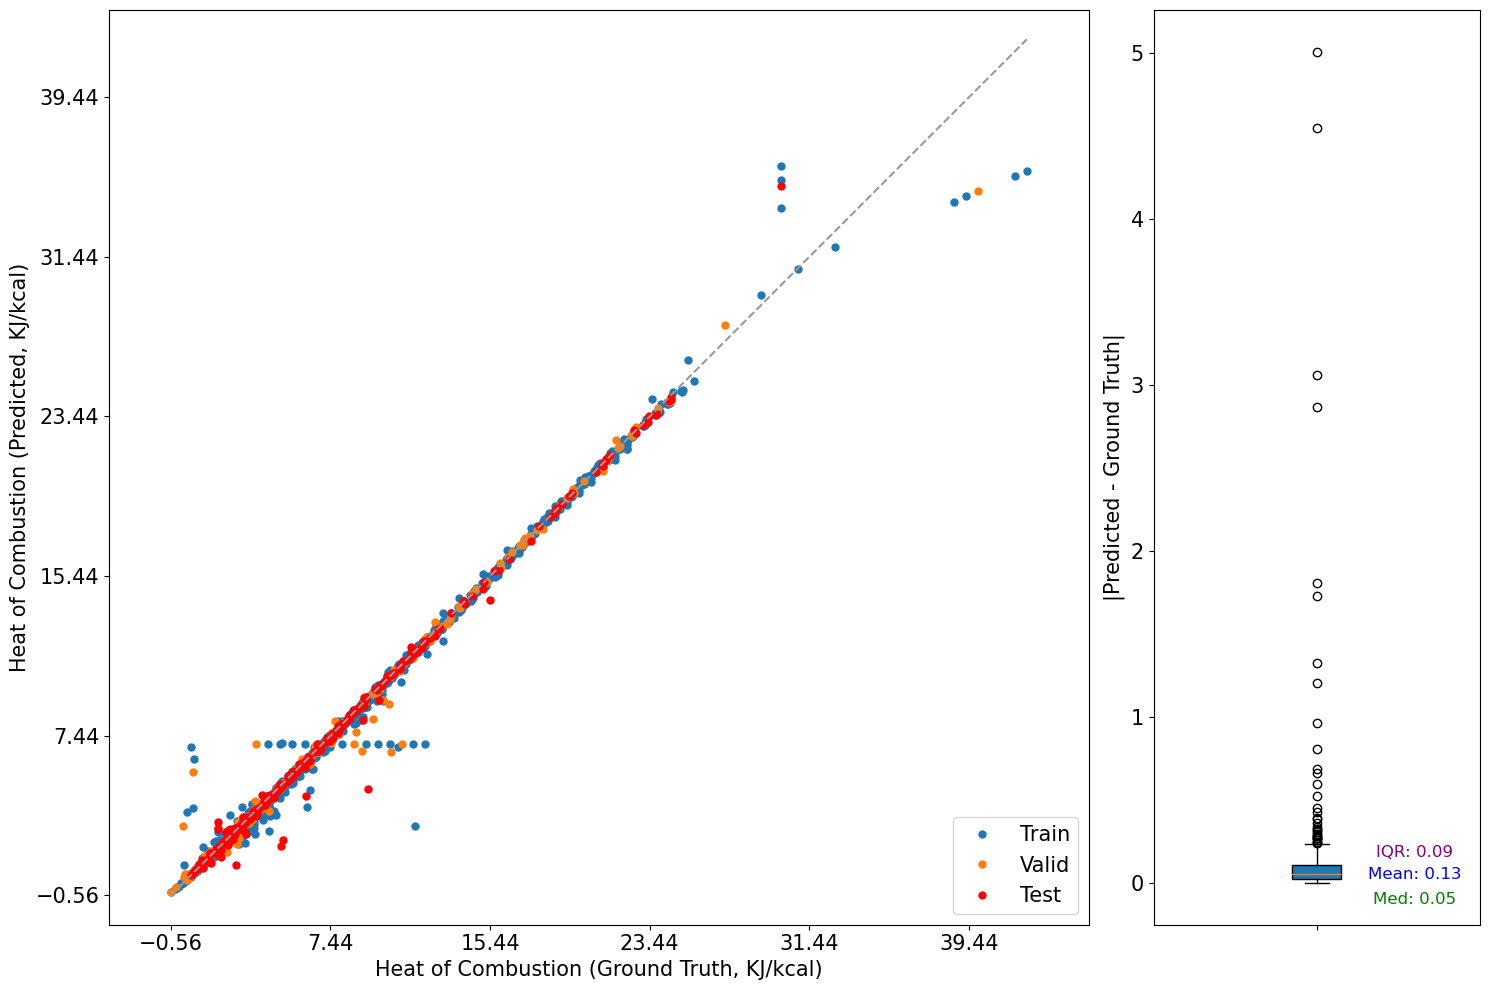

In [16]:
import matplotlib.pyplot as plt

test_residuals_abs = np.abs(HoC_test['VALUE'] - test_results)
test_residuals_abs_series = pd.Series(test_residuals_abs, index=HoC_test.index)

# calculate IQR
Q1 = np.percentile(test_residuals_abs, 25)
Q3 = np.percentile(test_residuals_abs, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = test_residuals_abs_series[(test_residuals_abs_series < lower_bound) | (test_residuals_abs_series > upper_bound)]

outlier_data = HoC_test.loc[outliers.index]

fig, axs = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [3, 1]})

# First subplot: Predicted vs Actual values
axs[0].axis('equal')
axs[0].set_xticks(np.arange(min(HoC_data.VALUE), max(HoC_data.VALUE), (max(HoC_data.VALUE)-min(HoC_data.VALUE))//5))
axs[0].set_yticks(np.arange(min(HoC_data.VALUE), max(HoC_data.VALUE), (max(HoC_data.VALUE)-min(HoC_data.VALUE))//5))    
axs[0].set_xlabel('Heat of Combustion (Ground Truth, KJ/kcal)', fontsize=15)
axs[0].set_ylabel('Heat of Combustion (Predicted, KJ/kcal)', fontsize=15)
axs[0].plot(HoC_train['VALUE'], train_results, '.', ms=10, label='Train')
axs[0].plot(HoC_valid['VALUE'], valid_results, '.', ms=10, label='Valid')    
axs[0].plot(HoC_test['VALUE'], test_results, '.',  ms=10, label='Test', color="red")
axs[0].legend(loc='lower right', fontsize=15)
axs[0].plot([min(HoC_data.VALUE), max(HoC_data.VALUE)], [min(HoC_data.VALUE), max(HoC_data.VALUE)], '--', color='.6')

# Second subplot: Box plot of absolute residuals
box = axs[1].boxplot(test_residuals_abs, patch_artist=True)
axs[1].set_title('', fontsize=15)
axs[1].set_ylabel('|Predicted - Ground Truth|', fontsize=15)
axs[1].set_xticklabels([''])

# Display additional information on the box plot such as mean and median
mean = np.mean(test_residuals_abs)
median = np.median(test_residuals_abs)

# Adjust text position
mean_offset = 1.5
median_offset = 1.5

axs[1].text(1.3, mean - 0.1, f'Mean: {mean:.2f}', ha='center', color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axs[1].text(1.3, mean - 0.25, f'Med: {median:.2f}', ha='center', color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

axs[1].text(1.3, Q3+0.05, f'IQR: {IQR:.2f}', ha='center', color='purple', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.tight_layout()
plt.show()

### 2-2-5. Outlier

In [17]:
outlier_data

,SMILES,Name,VALUE
64,NCc1ccccc1,benzylamine,3.057290
512,C1CCCCCCCCCC1,cycloundecane,6.766690
600,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(Br)Br,"1,1-dibromononatriacontane",23.763630
995,CC(C)CCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC(C)C,diisodecyl phthalate,15.450080
1348,CC1(C)CCC1,"1,1-dimethylcyclobutane",3.730180
1570,Cc1c(cccc1[N+]([O-])=O)[N+]([O-])=O,"2,6-dinitrotoluene",1.805940
1571,Cc1ccc(c(c1)[N+]([O-])=O)[N+]([O-])=O,"3,4-dinitrotoluene",1.805940
1585,C1COCCO1,"1,4-dioxane",2.189000
1625,CCCCCCCCCCCNCCCCCCCCCCC,diundecylamine,11.489100
1834,CC(O)=O.CC(O)=O.OCCO,ethylene glycol diacetate,2.715520


## 3. Distance-based applicability domain (AD) analysis 

=== HoC AD summary ===
 threshold(Tanimoto)  percentile_used(%)  N_test  N_in  N_out  MAE_overall   MAE_in  MAE_out  MAE_gap(out-in)
                0.45                   5     478   445     33     0.125897 0.119969 0.205827         0.085858

=== Lowest-similarity test compounds (top-k) ===
                    SMILES  nn_tanimoto    VALUE  Hoc_pred
           O=[S]1(=O)CCCC1     0.181818 2.392560  2.781152
           C1CCS(=O)(=O)C1     0.181818 2.664790  2.781151
                  Cn1cccc1     0.190476 2.551780  2.267577
      C1(=NC(=NC(=N1)N)N)N     0.230769 1.965643  1.366620
              C1CC2CC1C=C2     0.238095 4.029880  4.456552
      CC1=CC(=O)CC(C)(C)C1     0.240000 4.943820  4.851424
                       C#N     0.250000 0.641407  0.694941
C1(=O)NC(=NN1)[N+](=O)[O-]     0.280000 0.933869  0.871884
 CC[Al](CC)Cl.CC[Al](Cl)Cl     0.294118 4.970592  1.909160
              CC1(C)CCC=C1     0.315789 4.161250  4.202974


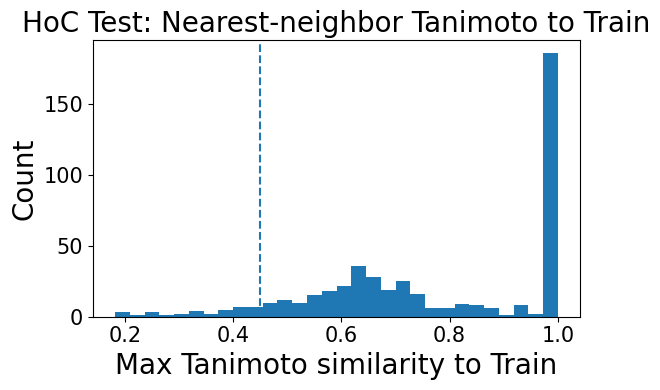

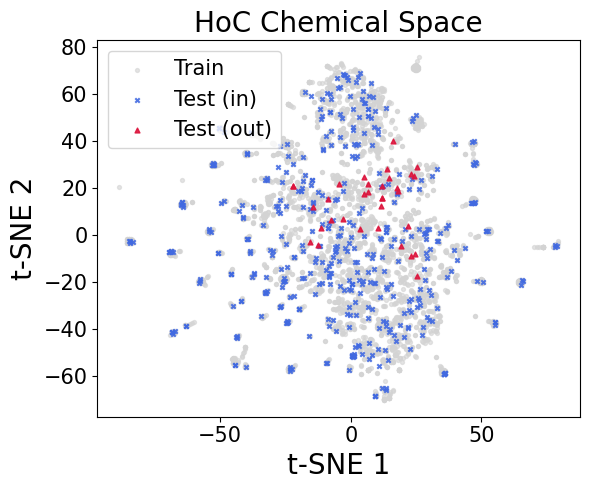

In [18]:
# 0. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE

# 1. Attach predictions (assumes lengths are consistent)
HoC_train = HoC_train.copy()
HoC_valid = HoC_valid.copy()
HoC_test  = HoC_test.copy()

HoC_train["Hoc_pred"] = np.asarray(train_results)
HoC_valid["Hoc_pred"] = np.asarray(valid_results)
HoC_test["Hoc_pred"]  = np.asarray(test_results)

# ---------------------------------------------------------------------
# User configuration
# ---------------------------------------------------------------------
SMILES_COL = "SMILES"   # molecular structure (SMILES)
Y_TRUE_COL = "VALUE"    # ground-truth property
Y_PRED_COL = "Hoc_pred" # model prediction (already attached above)

RADIUS = 2
N_BITS = 2048
SEED   = 42
PERC_CUT = 5  # use the lower p% of validation-set NN similarity as the AD threshold

# ---------------------------------------------------------------------
# Basic sanity checks
# ---------------------------------------------------------------------
for name, df in [("HoC_train", HoC_train), ("HoC_valid", HoC_valid), ("HoC_test", HoC_test)]:
    missing = [c for c in [SMILES_COL, Y_TRUE_COL, Y_PRED_COL] if c not in df.columns]
    if missing:
        raise KeyError(f"{name} is missing required columns: {missing}")

# ---------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------
def morgan_fp(smiles_series, radius=2, nBits=2048):
    """Generate Morgan fingerprints (BitVect) for a pandas Series of SMILES."""
    fps = []
    for s in smiles_series:
        mol = Chem.MolFromSmiles(str(s)) if pd.notna(s) else None
        if mol is None:
            fps.append(None)
        else:
            fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))
    return fps

def nearest_tanimoto_distribution(A_fps, B_fps):
    """
    For each fingerprint in A_fps, compute its maximum Tanimoto similarity
    against fingerprints in B_fps (nearest-neighbor similarity).
    """
    valid_B = [fp for fp in B_fps if fp is not None]
    res = []
    for fp in A_fps:
        if (fp is None) or (len(valid_B) == 0):
            res.append(np.nan)
        else:
            sims = DataStructs.BulkTanimotoSimilarity(fp, valid_B)
            res.append(np.max(sims))
    return np.array(res, dtype=float)

def mae(y_true, y_pred):
    arr = np.abs(np.asarray(y_true) - np.asarray(y_pred))
    return np.nanmean(arr)

def bv_to_np(fp, n_bits=N_BITS):
    """Convert an RDKit ExplicitBitVect to a numpy array."""
    arr = np.zeros((n_bits,), dtype=np.int8)
    if fp is not None:
        DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# ---------------------------------------------------------------------
# 1. Fingerprints
# ---------------------------------------------------------------------
train_fps = morgan_fp(HoC_train[SMILES_COL], radius=RADIUS, nBits=N_BITS)
valid_fps = morgan_fp(HoC_valid[SMILES_COL], radius=RADIUS, nBits=N_BITS)
test_fps  = morgan_fp(HoC_test[SMILES_COL],  radius=RADIUS, nBits=N_BITS)

# ---------------------------------------------------------------------
# 2. AD threshold: lower p% of validation NN similarity (valid -> train)
# ---------------------------------------------------------------------
valid_nn = nearest_tanimoto_distribution(valid_fps, train_fps)   # valid -> train
valid_nn_clean = valid_nn[~np.isnan(valid_nn)]
if len(valid_nn_clean) == 0:
    raise ValueError("Validation NN similarity (valid -> train) could not be computed. Please check SMILES and fingerprints.")

THRESH = float(np.percentile(valid_nn_clean, PERC_CUT))

# ---------------------------------------------------------------------
# 3. Label test points as in-domain / out-of-domain
# ---------------------------------------------------------------------
test_nn = nearest_tanimoto_distribution(test_fps, train_fps)     # test -> train

HoC_test = HoC_test.copy()
HoC_test["nn_tanimoto"] = test_nn
HoC_test["AD_flag"] = np.where(
    HoC_test["nn_tanimoto"] >= THRESH,
    "in-domain",
    "out-of-domain"
)

# ---------------------------------------------------------------------
# 4. Performance summary
# ---------------------------------------------------------------------
overall_mae = mae(HoC_test[Y_TRUE_COL], HoC_test[Y_PRED_COL])
in_mask  = HoC_test["AD_flag"] == "in-domain"
out_mask = HoC_test["AD_flag"] == "out-of-domain"

in_mae   = mae(HoC_test.loc[in_mask,  Y_TRUE_COL], HoC_test.loc[in_mask,  Y_PRED_COL])
out_mae  = mae(HoC_test.loc[out_mask, Y_TRUE_COL], HoC_test.loc[out_mask, Y_PRED_COL])

summary = pd.DataFrame({
    "threshold(Tanimoto)": [THRESH],
    "percentile_used(%)":  [PERC_CUT],
    "N_test":              [len(HoC_test)],
    "N_in":                [int(in_mask.sum())],
    "N_out":               [int(out_mask.sum())],
    "MAE_overall":         [overall_mae],
    "MAE_in":              [in_mae],
    "MAE_out":             [out_mae],
    "MAE_gap(out-in)":     [out_mae - in_mae],
})

print("=== HoC AD summary ===")
print(summary.to_string(index=False))

# Optional: show top-k lowest-similarity test compounds (useful for appendix tables)
k = min(10, len(HoC_test))
top_out = HoC_test.sort_values("nn_tanimoto", ascending=True).head(k)[
    [SMILES_COL, "nn_tanimoto", Y_TRUE_COL, Y_PRED_COL]
]
print("\n=== Lowest-similarity test compounds (top-k) ===")
print(top_out.to_string(index=False))

# ---------------------------------------------------------------------
# 5. Visualization 1: NN similarity distribution + AD threshold
# ---------------------------------------------------------------------
plt.figure(figsize=(6, 4))
vals = HoC_test["nn_tanimoto"].values
vals = vals[~np.isnan(vals)]
plt.hist(vals, bins=30)
plt.axvline(THRESH, linestyle="--")
plt.title("HoC Test: Nearest-neighbor Tanimoto to Train")
plt.xlabel("Max Tanimoto similarity to Train")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 6. Visualization 2: t-SNE of chemical space (Train vs Test in/out)
# ---------------------------------------------------------------------
X_train = np.vstack([bv_to_np(fp) for fp in train_fps])
X_test  = np.vstack([bv_to_np(fp) for fp in test_fps])
X_all   = np.vstack([X_train, X_test])

tsne = TSNE(
    n_components=2,
    init="random",
    learning_rate="auto",
    random_state=SEED,
    perplexity=30
)
Z = tsne.fit_transform(X_all)
Z_train = Z[:len(X_train)]
Z_test  = Z[len(X_train):]

plt.figure(figsize=(6, 5))
plt.scatter(Z_train[:, 0], Z_train[:, 1], s=8, alpha=0.6, color="lightgrey", label="Train")

test_in_idx  = (HoC_test["AD_flag"].values == "in-domain")
test_out_idx = ~test_in_idx

plt.scatter(
    Z_test[test_in_idx, 0],
    Z_test[test_in_idx, 1],
    s=10,
    alpha=0.9,
    marker="x",
    color="royalblue",
    label="Test (in)"
)
plt.scatter(
    Z_test[test_out_idx, 0],
    Z_test[test_out_idx, 1],
    s=12,
    alpha=0.9,
    marker="^",
    color="crimson",
    label="Test (out)"
)

plt.title("HoC Chemical Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()
